## Time Series and ARIMA Implementation

#### Importing Libraries

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Loading the dataset

In [3]:
data = pd.read_csv('processed_data.csv', encoding = 'ISO-8859-1')
data.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-29,83.13,118.127103,6.93,28.71,33.72,23.483476,6.93,49.52,59.76,0.02,0.00,3.14,209.0,Poor
1,Ahmedabad,2015-01-30,79.84,118.127103,13.85,28.68,41.08,23.483476,13.85,48.49,97.07,0.04,0.00,4.81,328.0,Very Poor
2,Ahmedabad,2015-01-31,94.52,118.127103,24.39,32.66,52.61,23.483476,24.39,67.39,111.33,0.24,0.01,7.67,514.0,Severe
3,Ahmedabad,2015-02-01,135.99,118.127103,43.48,42.08,84.57,23.483476,43.48,75.23,102.70,0.40,0.04,25.87,782.0,Severe
4,Ahmedabad,2015-02-02,178.33,118.127103,54.56,35.31,72.80,23.483476,54.56,55.04,107.38,0.46,0.06,35.61,914.0,Severe


In [4]:
data.shape

(24850, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24850 entries, 0 to 24849
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        24850 non-null  object 
 1   Date        24850 non-null  object 
 2   PM2.5       24850 non-null  float64
 3   PM10        24850 non-null  float64
 4   NO          24850 non-null  float64
 5   NO2         24850 non-null  float64
 6   NOx         24850 non-null  float64
 7   NH3         24850 non-null  float64
 8   CO          24850 non-null  float64
 9   SO2         24850 non-null  float64
 10  O3          24850 non-null  float64
 11  Benzene     24850 non-null  float64
 12  Toluene     24850 non-null  float64
 13  Xylene      24850 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.0+ MB


In [6]:
from sklearn.preprocessing import OrdinalEncoder

# Define order of categories for AQI_Bucket
categories_order = [['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']]

# Create encoder object
ordinal_encoder = OrdinalEncoder(categories=categories_order)

# Reshape target variable to fit the encoder's expected format
y_reshaped = data['AQI_Bucket'].values.reshape(-1, 1)

# Apply encoder to the target variable
data['Encoded_AQI_Bucket'] = ordinal_encoder.fit_transform(y_reshaped)

# Use 'Encoded_AQI_Bucket' as target variable
y = data['Encoded_AQI_Bucket']

# Drop AQI_Bucket
data = data.drop(columns=['AQI_Bucket'])

In [7]:
data

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Encoded_AQI_Bucket
0,Ahmedabad,2015-01-29,83.13,118.127103,6.93,28.71,33.72,23.483476,6.93,49.52,59.76,0.02000,0.000000,3.140000,209.0,3.0
1,Ahmedabad,2015-01-30,79.84,118.127103,13.85,28.68,41.08,23.483476,13.85,48.49,97.07,0.04000,0.000000,4.810000,328.0,4.0
2,Ahmedabad,2015-01-31,94.52,118.127103,24.39,32.66,52.61,23.483476,24.39,67.39,111.33,0.24000,0.010000,7.670000,514.0,5.0
3,Ahmedabad,2015-02-01,135.99,118.127103,43.48,42.08,84.57,23.483476,43.48,75.23,102.70,0.40000,0.040000,25.870000,782.0,5.0
4,Ahmedabad,2015-02-02,178.33,118.127103,54.56,35.31,72.80,23.483476,54.56,55.04,107.38,0.46000,0.060000,35.610000,914.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24845,Visakhapatnam,2020-06-27,15.02,50.940000,7.68,25.06,19.54,12.470000,0.47,8.55,23.30,2.24000,12.070000,0.730000,41.0,0.0
24846,Visakhapatnam,2020-06-28,24.38,74.090000,3.42,26.06,16.53,11.990000,0.52,12.72,30.14,0.74000,2.210000,0.380000,70.0,1.0
24847,Visakhapatnam,2020-06-29,22.91,65.730000,3.45,29.53,18.33,10.710000,0.48,8.42,30.96,0.01000,0.010000,0.000000,68.0,1.0
24848,Visakhapatnam,2020-06-30,16.64,49.970000,4.05,29.26,18.80,10.030000,0.52,9.84,28.30,0.00000,0.000000,0.000000,54.0,1.0


In [10]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Extract the 'year' component
data['year'] = data['Date'].dt.year

min_year = data['year'].min()
data['year'].fillna(min_year, inplace=True)

# Convert the 'year' column to integer
data['year'] = data['year'].astype(int)

In [11]:
data

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Encoded_AQI_Bucket,year
0,Ahmedabad,2015-01-29,83.13,118.127103,6.93,28.71,33.72,23.483476,6.93,49.52,59.76,0.02000,0.000000,3.140000,209.0,3.0,2015
1,Ahmedabad,2015-01-30,79.84,118.127103,13.85,28.68,41.08,23.483476,13.85,48.49,97.07,0.04000,0.000000,4.810000,328.0,4.0,2015
2,Ahmedabad,2015-01-31,94.52,118.127103,24.39,32.66,52.61,23.483476,24.39,67.39,111.33,0.24000,0.010000,7.670000,514.0,5.0,2015
3,Ahmedabad,2015-02-01,135.99,118.127103,43.48,42.08,84.57,23.483476,43.48,75.23,102.70,0.40000,0.040000,25.870000,782.0,5.0,2015
4,Ahmedabad,2015-02-02,178.33,118.127103,54.56,35.31,72.80,23.483476,54.56,55.04,107.38,0.46000,0.060000,35.610000,914.0,5.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24845,Visakhapatnam,2020-06-27,15.02,50.940000,7.68,25.06,19.54,12.470000,0.47,8.55,23.30,2.24000,12.070000,0.730000,41.0,0.0,2020
24846,Visakhapatnam,2020-06-28,24.38,74.090000,3.42,26.06,16.53,11.990000,0.52,12.72,30.14,0.74000,2.210000,0.380000,70.0,1.0,2020
24847,Visakhapatnam,2020-06-29,22.91,65.730000,3.45,29.53,18.33,10.710000,0.48,8.42,30.96,0.01000,0.010000,0.000000,68.0,1.0,2020
24848,Visakhapatnam,2020-06-30,16.64,49.970000,4.05,29.26,18.80,10.030000,0.52,9.84,28.30,0.00000,0.000000,0.000000,54.0,1.0,2020


In [12]:
data_so2 = data[["Date", "SO2"]]
data_so2 = data_so2.set_index("Date")
data_so2 = data_so2.dropna()

<AxesSubplot: xlabel='Date'>

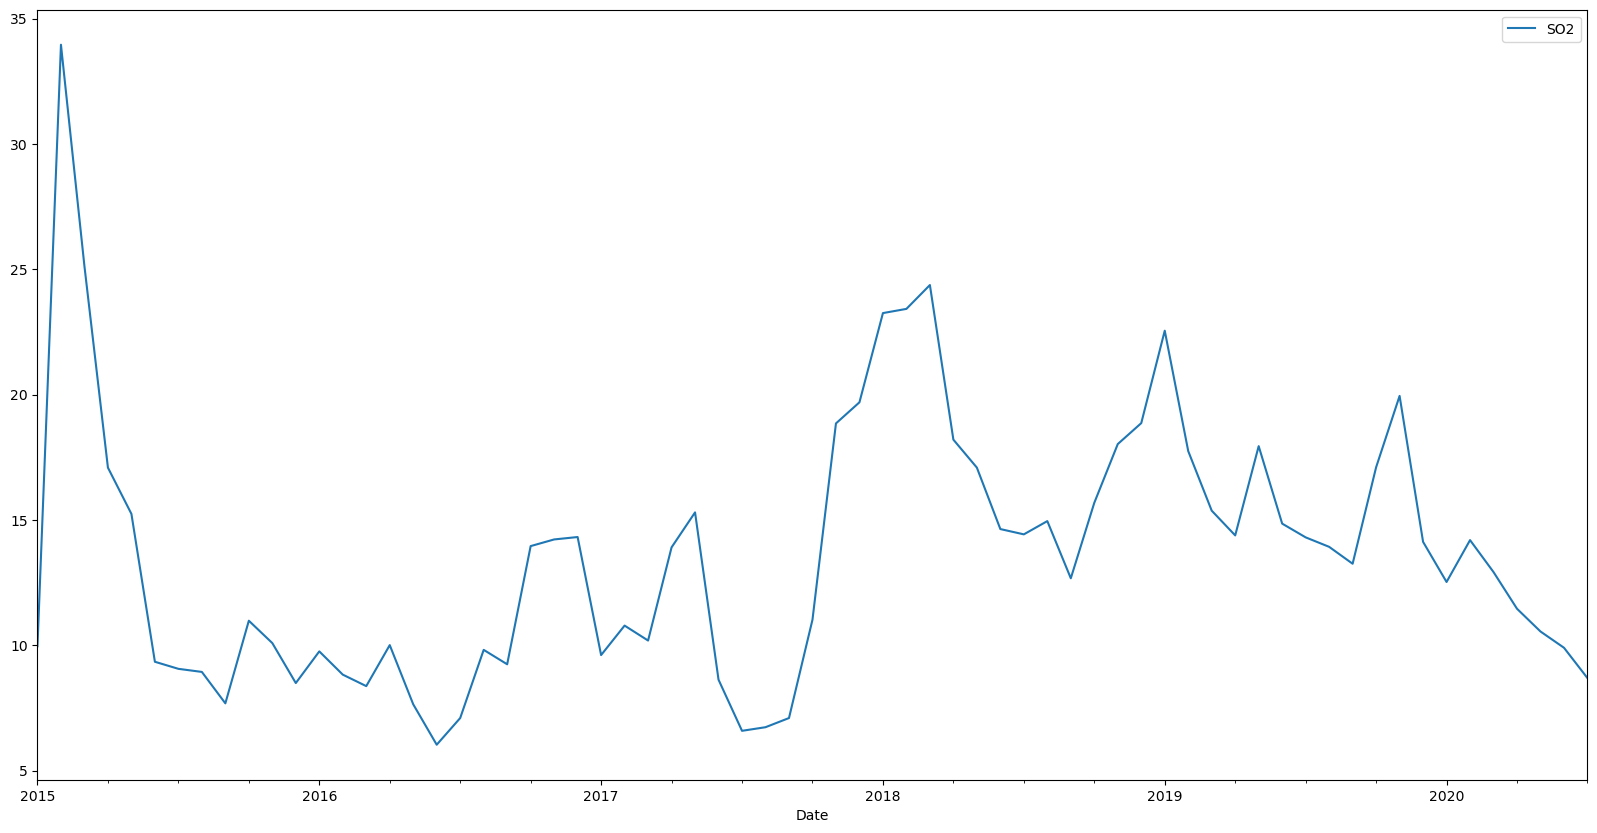

In [13]:
data_so2_resample = data_so2.resample(rule = "M").mean().ffill()
data_so2_resample.plot(figsize = (20,10))

<AxesSubplot: xlabel='Date'>

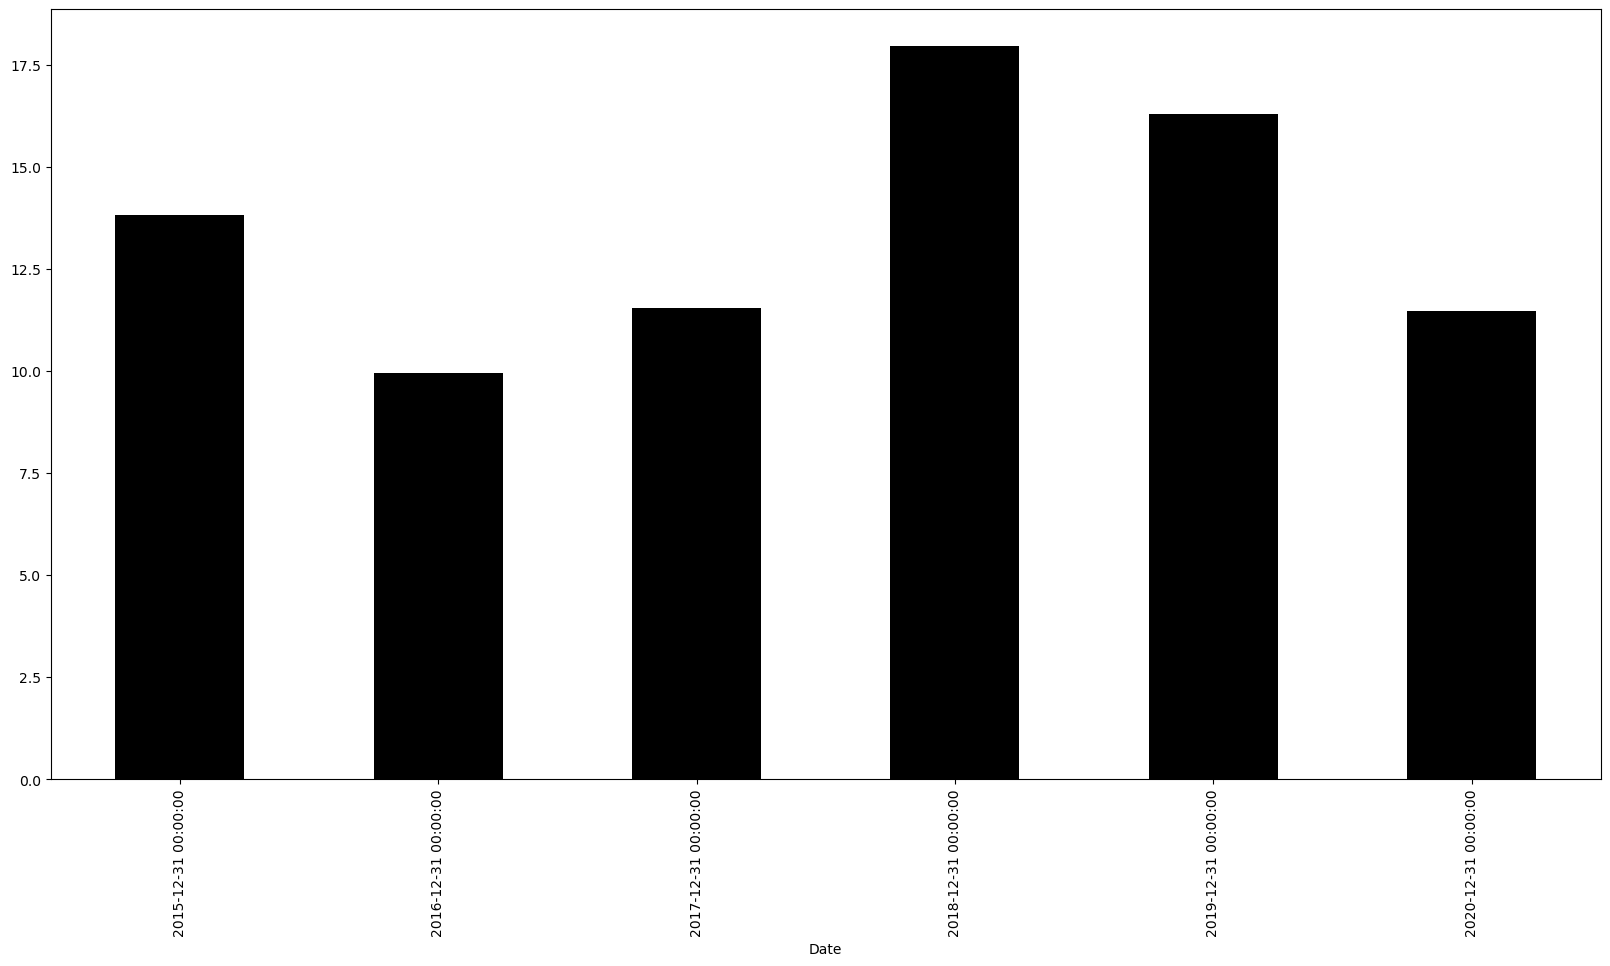

In [17]:
data_so2_resample["SO2"].resample("A").mean().plot.bar(figsize = (20,10), color={"black"})

<AxesSubplot: xlabel='Date'>

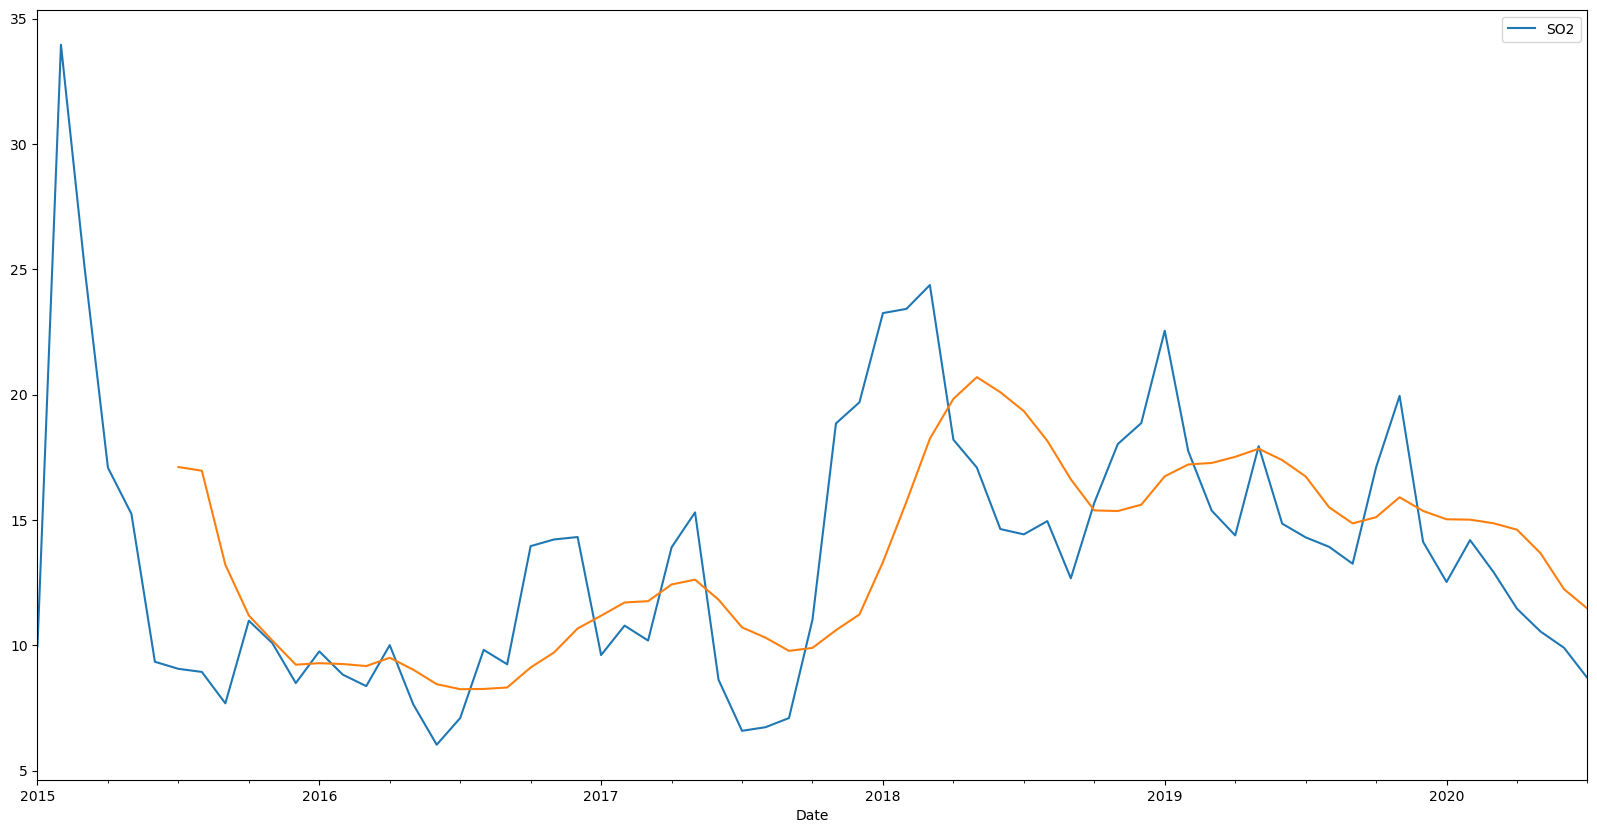

In [19]:
data_so2_resample.plot(figsize = (20,10))
data_so2_resample.rolling(window = 7).mean()["SO2"].plot(figsize = (20,10))

### Exponential weighted moving average EWMA apply more weight to value more recent

<AxesSubplot: xlabel='Date'>

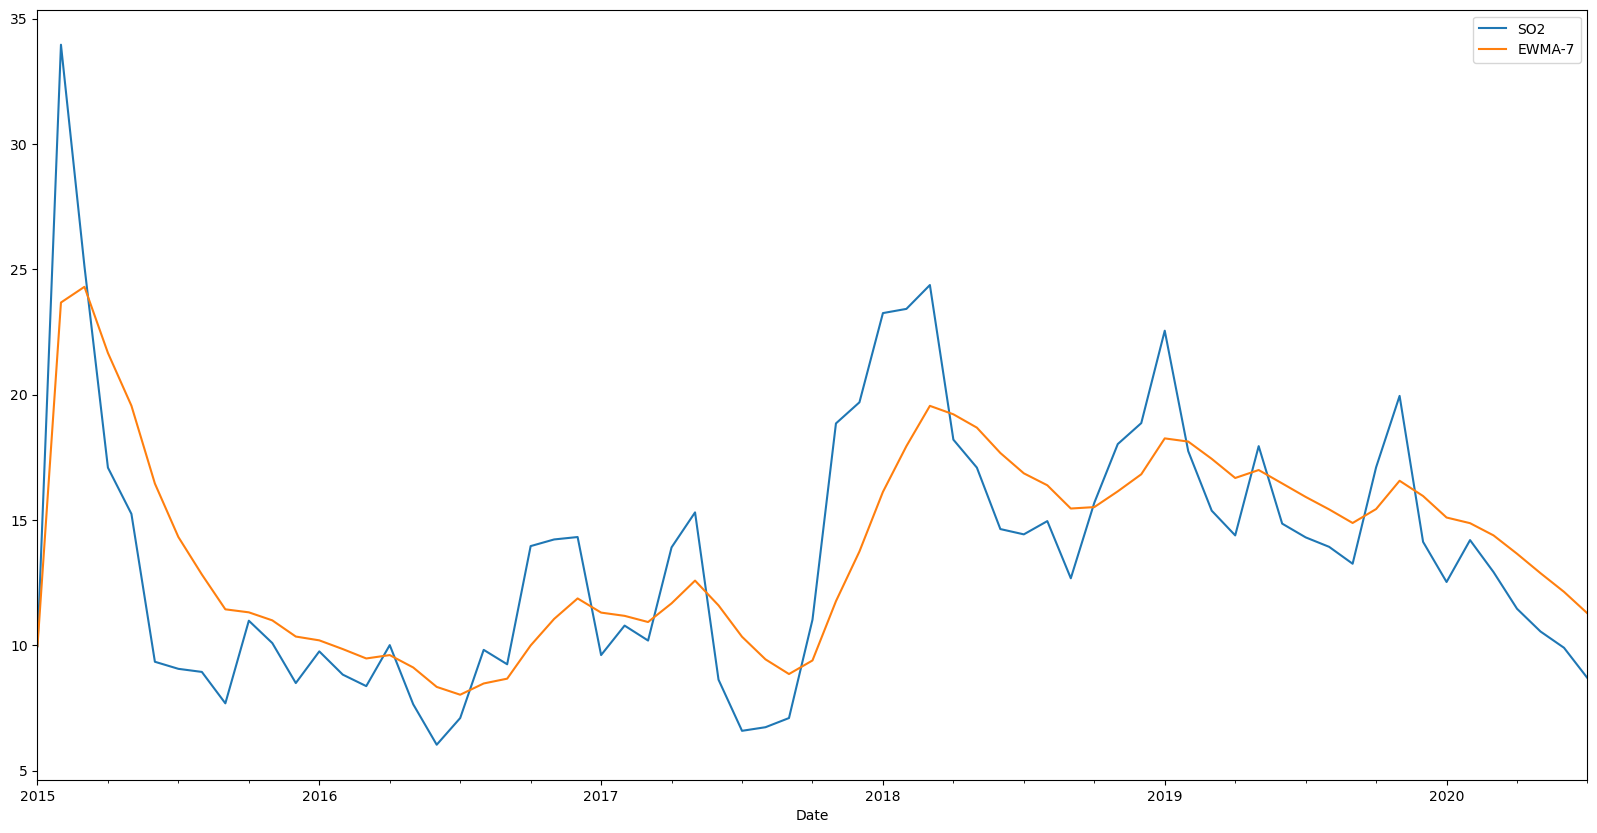

In [23]:
data_so2_resample["EWMA-7"] = data_so2_resample["SO2"].ewm(span=7).mean()
data_so2_resample.plot(figsize = (20,10))

### Exponential Smoothing State Space Mode (ETS)

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data_so2_resample["SO2"], model = "multiplicative") 

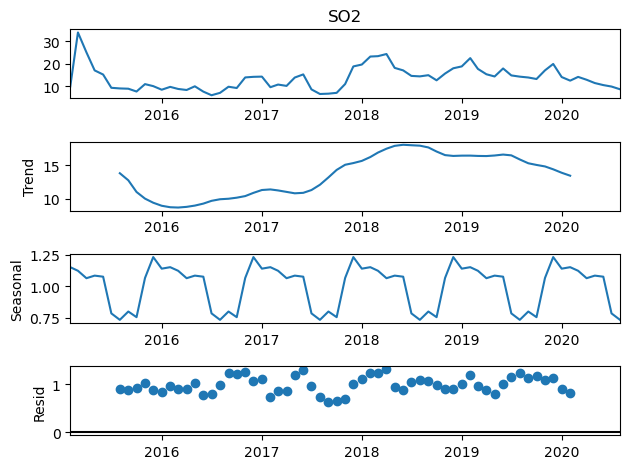

In [25]:
fig = result.plot()

### ARIMA (Autoregressive Integrated Moving Averages)

In [27]:
# To check if the data is stationary or non-stationary

from statsmodels.tsa.stattools import adfuller
result = adfuller(data_so2_resample["SO2"])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.493898871033596
p-value : 0.00814517348517472
#Lags Used : 0
Number of Observations Used : 66
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


                            AutoReg Model Results                             
Dep. Variable:                    AQI   No. Observations:                  100
Model:                     AutoReg(1)   Log Likelihood                -129.785
Method:               Conditional MLE   S.D. of innovations              0.898
Date:                Tue, 31 Oct 2023   AIC                            265.569
Time:                        18:34:24   BIC                            273.355
Sample:                             1   HQIC                           268.719
                                  100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3956      1.828      1.310      0.190      -1.187       5.979
AQI.L1         0.9732      0.019     49.911      0.000       0.935       1.011
                                    Roots           

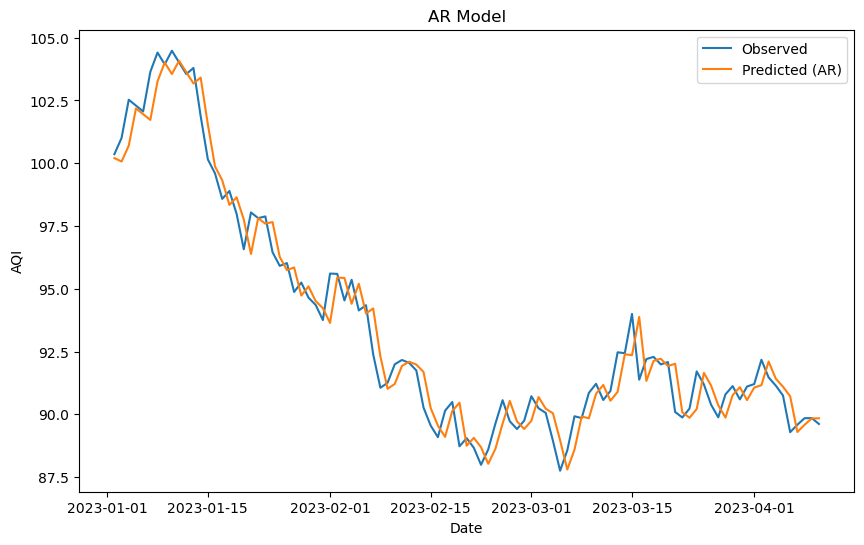

In [47]:
np.random.seed(42)
n = 100
time = pd.date_range(start="2023-01-01", periods=n, freq="D")
data = np.cumsum(np.random.randn(n)) + 100

# Creating a pandas DataFrame with the time series data
data = pd.DataFrame({"Date": time, "AQI": data})

# Specifying the order of the AR model (e.g., AR(1))
order = 1

# Fitting the AutoReg model
model = sm.tsa.AutoReg(data["AQI"], lags=order, old_names=False)
results = model.fit()

# Printing the model summary
print(results.summary())

# To get the number of lags
n_lags = len(results.ar_lags)

# Slicing the time series data to match the number of predicted values
data = data.iloc[n_lags:]

# Forecasting
forecast = results.predict(start=len(data), end=len(data) + n_lags - 1)

# Creating a date range for the forecasted dates
forecast_dates = pd.date_range(start=data["Date"].iloc[-1] + pd.DateOffset(1), periods=n_lags, freq="D")

# Plotting the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(data["Date"], data["AQI"], label="Observed")
plt.plot(data["Date"], results.fittedvalues, label="Predicted (AR)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.title("AR Model")
plt.show()

In [46]:
# Evaluating using metrics
mse = mean_squared_error(data["AQI"].tail(n_lags), forecast)
mae = mean_absolute_error(data["AQI"].tail(n_lags), forecast)
rmse = np.sqrt(mse)

print("Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Evaluation Metrics:
Mean Squared Error (MSE): 0.051057042974740875
Mean Absolute Error (MAE): 0.22595805578633588
Root Mean Squared Error (RMSE): 0.22595805578633588
